Steps are:

- select a reconstruction time
- the code determines which paleogeography stage this falls within, gets the start and end times
- load the relevant precomputed multipoint files, and in the process assign an integer to the different types for use in interpolation steps (e.g. set land to be 1, shallow marine to be 2, etc)

- for land and marine



In [1]:
import sys
sys.path.append('../paleogeography')
sys.path.append('../paleotopography')
sys.path.append('../pigplates/')
sys.path.append('../pygplates2014/')
sys.path.append('/Users/Simon/GIT/PlateTectonicTools/')

import pygplates
import glob, re
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import xarray as xr

import polygon_processing as pp
import paleogeography as pg
import paleogeography_tweening as pgt
import paleotopography as pt

from proximity_query import *
from create_gpml import create_gpml_regular_long_lat_mesh
import points_in_polygons
from sphere_tools import sampleOnSphere
import points_spatial_tree

from ptt.utils.call_system_command import call_system_command
import tempfile

%matplotlib inline
%load_ext autoreload
%autoreload 2


reconstruction_basedir = '../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles/'
tween_basedir = './tween_feature_collections/'
file_format = 'gpmlz'

output_dir = '/Users/simon/cloudstor/Shared/Paleotopography_Grids/2016_v5/'

netcdf3_output = False

#rotation_model = pygplates.RotationModel(['%s/Global_EB_250-0Ma_GK07_Matthews++.rot' % reconstruction_basedir,
#                                          '%s/Global_EB_410-250Ma_GK07_Matthews++.rot' % reconstruction_basedir])
#rotation_file = '%s/Global_EarthByte_230-0Ma_GK07_AREPS.rot' % reconstruction_basedir
MODELDIR = '/Users/simon/GIT/agegrid-dev/input_files/Global_Model_WD_Internal_Release_2016_v5/'
rotation_file = ['%s/Global_EB_250-0Ma_GK07_2016_v5.rot' % MODELDIR,\
                 '%s/Global_EB_410-250Ma_GK07_2016_v5.rot' % MODELDIR]




COBterrane_file = '%s/Global_EarthByte_GeeK07_COB_Terranes_Matthews_etal.gpml' % reconstruction_basedir

#agegrid_file_template = '/Users/Simon/Data/AgeGrids/Agegrids_30m_20151002_2015_v1_r756/agegrid_30m_%d.grd'
agegrid_file_template = '/Users/Simon/cloudstor/age_grids/2016_v5_r1031/raw/sphtmp_mask_%0.1fMa.nc'


#############################################
## Set the heights for different environment
#############################################
depth_for_unknown_ocean = -1000
# ----------------------------------
shallow_marine_elevation = -200.
# ----------------------------------
lowland_elevation = 200.
# ----------------------------------
max_mountain_elevation = 1500.
# NOTE - this height is actually the mountain height IN ADDITION TO the lowland height
# so that the maximum absolute elevation would be [lowland_elevation + max_mountain_elevation]
# TODO should call this 'mountain_relief'???
#############################################

# the grid sampling for the output
sampling = 1.0

# this number controls how small polygons are exclude when merging the COB terranes into 
# land/sea masking polygons
area_threshold = 0.0001

# used for quadtree
subdivision_depth = 2

# this buffer defines the smoothness of the topography at the transition from 'lowland' to 'mountain'
# the distance defined here is the distance over which heights ramp from the lowland elevation to the 
# mountain elevation defined above. (the ramping takes place from the edge of the mountain range inwards
# towards the mountain interior). Any parts of the mountain range greater than this buffer distance from 
# the edge will have a uniform height equal to max_mountain_elevation
mountain_buffer_distance_degrees = 0.001
#mountain_buffer_distance_degrees = 2.

# choose here either 'ocean' or 'land'
# this determines which grid takes precedence where both the age grid and the 
# paleogeographies overlap and contain valid values
land_or_ocean_precedence = 'land'

# this number is used in the final grdfilter step to smooth the output 
# NOTE this value is ignored if 'merge_with_bathymetry' is set to False
grid_smoothing_wavelength_kms = 400.

time_min = 0.
time_max = 401.
time_step = 5.

merge_with_bathymetry = True


####################################################

# make a sorted list of the (midpoint) times for paleogeography polygons
tmp = glob.glob('%s/*/' % reconstruction_basedir)

paleogeography_timeslice_list = []
for tm in tmp:
    paleogeography_timeslice_list.append(float(re.findall(r'\d+Ma+',tm)[1][:-2]))

paleogeography_timeslice_list.sort()

paleogeography_timeslice_list = np.array(paleogeography_timeslice_list)

print paleogeography_timeslice_list


[  6.  14.  22.  33.  45.  53.  76.  90. 105. 126. 140. 152. 169. 195.
 218. 232. 255. 277. 287. 302. 328. 348. 368. 396.]


Working on Time 0.00Ma

Selected Time is in the stage 0.00Ma to 6.00Ma
Temporary fix for valid time
./present_day_paleogeography.gmt


/Users/Simon/GIT/paleogeography/paleogeography.py:357: RuntimeWarning: invalid value encountered in greater_equal
  paleodepth[age_array>=20.] = 5651 - 2473*np.exp(-0.0278*age_array[age_array>=20.])
paleotopography.py:406: RuntimeWarning: invalid value encountered in greater
  not_bathy_index = np.greater(topoZ,depth_for_unknown_ocean)


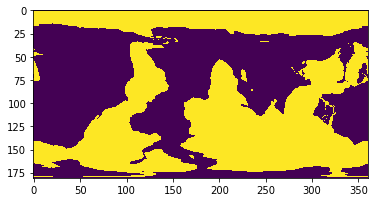

Working on Time 5.00Ma

Selected Time is in the stage 0.00Ma to 6.00Ma
./present_day_paleogeography.gmt
['../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_6Ma/m_fig64_11_2_PresentDay_Paleogeog_Matthews2016_6.00Ma.shp']


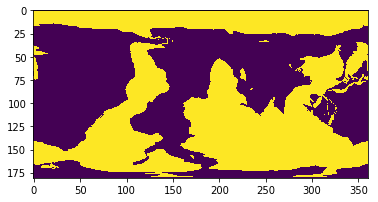

Working on Time 10.00Ma

Selected Time is in the stage 6.00Ma to 14.00Ma
['../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_6Ma/m_fig64_11_2_PresentDay_Paleogeog_Matthews2016_6.00Ma.shp']
['../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_14Ma/m_fig62_20_11_PresentDay_Paleogeog_Matthews2016_14.00Ma.shp']


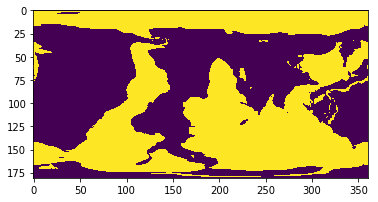

Working on Time 15.00Ma

Selected Time is in the stage 14.00Ma to 22.00Ma
['../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_14Ma/m_fig62_20_11_PresentDay_Paleogeog_Matthews2016_14.00Ma.shp']
['../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_22Ma/m_fig60_29_20_PresentDay_Paleogeog_Matthews2016_22.00Ma.shp']


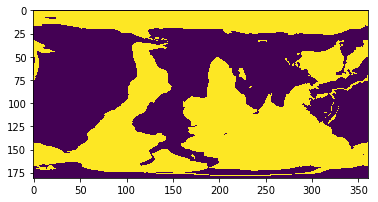

Working on Time 20.00Ma

Selected Time is in the stage 14.00Ma to 22.00Ma
['../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_14Ma/m_fig62_20_11_PresentDay_Paleogeog_Matthews2016_14.00Ma.shp']
['../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_22Ma/m_fig60_29_20_PresentDay_Paleogeog_Matthews2016_22.00Ma.shp']


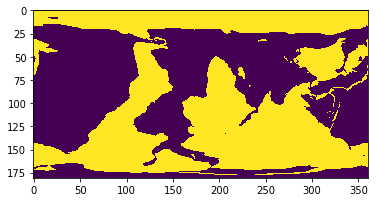

Working on Time 25.00Ma

Selected Time is in the stage 22.00Ma to 33.00Ma
['../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_22Ma/m_fig60_29_20_PresentDay_Paleogeog_Matthews2016_22.00Ma.shp']
['../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_33Ma/m_fig58_37_29_PresentDay_Paleogeog_Matthews2016_33.00Ma.shp']


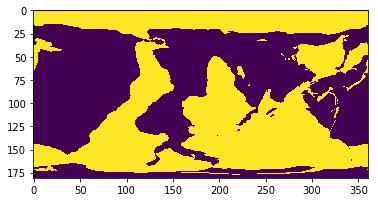

Working on Time 30.00Ma

Selected Time is in the stage 22.00Ma to 33.00Ma
['../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_22Ma/m_fig60_29_20_PresentDay_Paleogeog_Matthews2016_22.00Ma.shp']
['../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_33Ma/m_fig58_37_29_PresentDay_Paleogeog_Matthews2016_33.00Ma.shp']


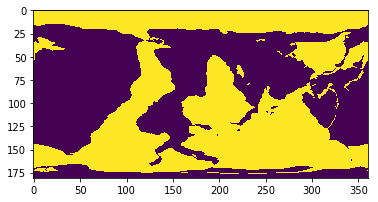

Working on Time 35.00Ma

Selected Time is in the stage 33.00Ma to 45.00Ma
['../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_33Ma/m_fig58_37_29_PresentDay_Paleogeog_Matthews2016_33.00Ma.shp']
['../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_45Ma/m_fig56_49_37_PresentDay_Paleogeog_Matthews2016_45.00Ma.shp']


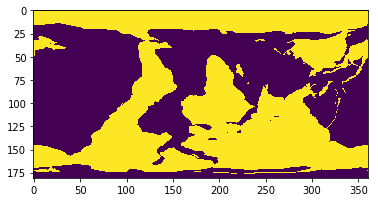

Working on Time 40.00Ma

Selected Time is in the stage 33.00Ma to 45.00Ma
['../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_33Ma/m_fig58_37_29_PresentDay_Paleogeog_Matthews2016_33.00Ma.shp']
['../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_45Ma/m_fig56_49_37_PresentDay_Paleogeog_Matthews2016_45.00Ma.shp']


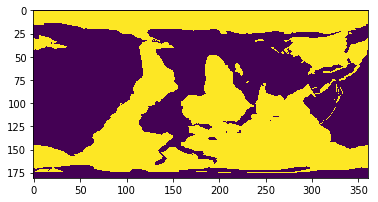

Working on Time 45.00Ma

Selected Time is in the stage 45.00Ma to 53.00Ma
Temporary fix for valid time
['../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_45Ma/m_fig56_49_37_PresentDay_Paleogeog_Matthews2016_45.00Ma.shp']


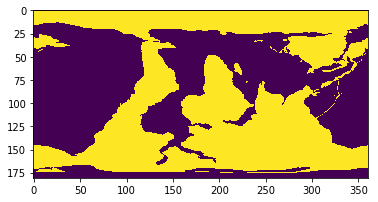

Working on Time 50.00Ma

Selected Time is in the stage 45.00Ma to 53.00Ma
['../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_45Ma/m_fig56_49_37_PresentDay_Paleogeog_Matthews2016_45.00Ma.shp']
['../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']


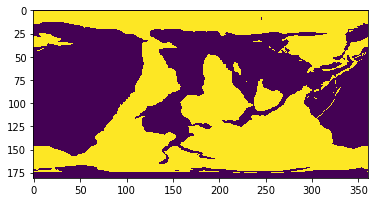

Working on Time 55.00Ma

Selected Time is in the stage 53.00Ma to 76.00Ma
['../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']
['../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']


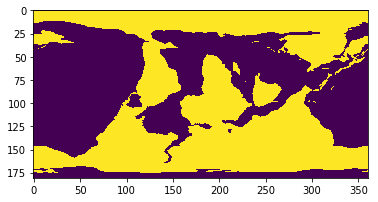

Working on Time 60.00Ma

Selected Time is in the stage 53.00Ma to 76.00Ma
['../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']
['../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']


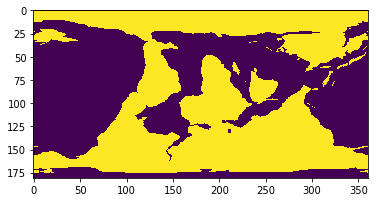

Working on Time 65.00Ma

Selected Time is in the stage 53.00Ma to 76.00Ma
['../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']
['../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']


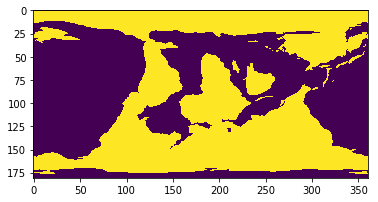

Working on Time 70.00Ma

Selected Time is in the stage 53.00Ma to 76.00Ma
['../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_53Ma/m_fig54_58_49_PresentDay_Paleogeog_Matthews2016_53.00Ma.shp']
['../paleogeography/Paleogeography_Matthews2016_410-2Ma_Shapefiles//PresentDay_Paleogeog_Matthews2016_76Ma/m_fig52_81_58_PresentDay_Paleogeog_Matthews2016_76.00Ma.shp']


KeyboardInterrupt: 

In [3]:
from joblib import Parallel, delayed

# prepend 0 to the list, since this is not covered in published paleogeography sequence
paleogeography_timeslice_list = np.hstack((0,paleogeography_timeslice_list))
 
num_cpus = 1

#time_min = 260.
#time_max = 261.
#time_step = 5.

if num_cpus==1:
    
    for reconstruction_time in np.arange(time_min,time_max+time_step,time_step):

        pt.paleotopography_job(reconstruction_time, paleogeography_timeslice_list, 
                               tween_basedir, reconstruction_basedir, output_dir, 
                               file_format, rotation_file, COBterrane_file, agegrid_file_template,
                               lowland_elevation, shallow_marine_elevation, max_mountain_elevation, depth_for_unknown_ocean, 
                               sampling, mountain_buffer_distance_degrees, area_threshold,
                               grid_smoothing_wavelength_kms, merge_with_bathymetry, land_or_ocean_precedence,
                               netcdf3_output)

else:
    Parallel(n_jobs=num_cpus)(delayed(pt.paleotopography_job) \
                              (reconstruction_time, paleogeography_timeslice_list, 
                               tween_basedir, reconstruction_basedir, output_dir, 
                               file_format, rotation_file, COBterrane_file, agegrid_file_template,
                               lowland_elevation, shallow_marine_elevation, max_mountain_elevation, depth_for_unknown_ocean, 
                               sampling, mountain_buffer_distance_degrees, area_threshold,
                               grid_smoothing_wavelength_kms, merge_with_bathymetry, land_or_ocean_precedence,
                               netcdf3_output)
                              for reconstruction_time in np.arange(time_min,time_max+time_step,time_step))
                              
                              

In [43]:
GW = pygplates.FeatureCollection('GatewayMasks.gpml')

for feature in GW:
    tmp = feature.get(pygplates.PropertyName.create_gpml('subcategory'))  #value('gpml:subcategory')
    print tmp


gpml:subcategory [ gateway ]
